# HOMEWORK PART 1

---

1. Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). Try also bagging the DMD to improve the results. See: https://github.com/duqbo/optdmd (MATLAB) and https://github.com/kunert/py-optDMD (Python)

2. Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. Try also bagging the DMD to improve the results.

3. Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d.

4. Find the best fit nonlinear, dynamical systems model to the data using bagging sparse regression SINDy (See: https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb)

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, splrep
from scipy.linalg import hankel
from scipy.integrate import solve_ivp
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error

from tabulate import tabulate
from Utility.FunctionsDMD import DMD, DMDprediction, recondmd
from Utility.PythonBOPDMD.optimalDMD import optdmd
from Utility.lotkavolterra import LotkaVolterra

import pysindy as ps
from pysindy.utils.odes import lotka

print(f"PySINDY version: {ps.__version__}")

#plt.style.use('science')

In [ ]:
path = os.path.join("..", "Data", "Lynx-Snowshoe.csv")
path = "/content/drive/MyDrive/PhD/MODELLING FROM MEASUREMENT/Modelling-From-Measurements/Data/Lynx-Snowshoe.csv"
data = pd.read_csv(path)

yr = data['Year']
sh = data['Snowshoe Hare Pelts(thousands)']
cl = data['Canadian Lynx Pelts(thousands)']

dt = 2

time = np.arange(0, max(yr) - min(yr) + dt, dt)

data.head()

,Year,Snowshoe Hare Pelts(thousands),Canadian Lynx Pelts(thousands)
0,1845,20,32
1,1847,20,50
2,1849,52,12
3,1851,83,10
4,1853,64,13


# Request  n° 1

- Develop a DMD model to forecast the future population states (note, DMD with two time series can only give you two eigenvalues). \
    Try also bagging the DMD to improve the results. See: 
    - https://github.com/duqbo/optdmd (MATLAB) 
    - https://github.com/kunert/py-optDMD (Python)

In [ ]:
# Interpolation of the data series, the interpolation with the B-Splne function from SciPy have reasulted in some values lower than 0 replaced here with 1

sh_int = splrep(time, sh)
cl_int = splrep(time, cl)

dt = 0.1

yr_new = np.arange(min(yr), max(yr) + dt, dt)

t_new = np.arange(0, max(yr) - min(yr) + dt, dt)

sh_new = splev(t_new, sh_int)
tmp = sh_new <= 1
sh_new[tmp] = 1

cl_new = splev(t_new, cl_int)
tmp = cl_new <= 1
cl_new[tmp] = 1

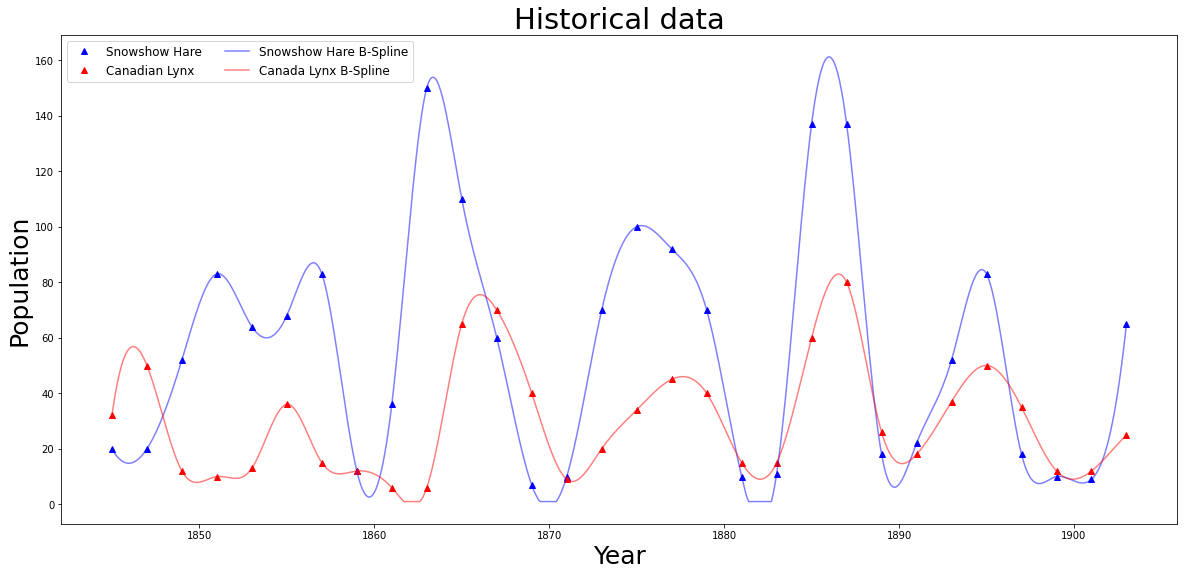

In [ ]:
fig = plt.figure(figsize=(20, 9))

plt.plot(yr, sh, '^', linewidth='2', color='blue')
plt.plot(yr, cl, '^', linewidth='2', color='red') 
plt.plot(yr_new, sh_new, color='blue', alpha= 0.5)
plt.plot(yr_new, cl_new, color='red', alpha = 0.5)
plt.title('Historical data', fontsize = 29)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Population', fontsize = 25)
plt.legend(['Snowshow Hare', 'Canadian Lynx', 'Snowshow Hare B-Spline', 'Canada Lynx B-Spline'], fontsize = 12, ncol=2)

#fig.savefig('Figures/population_data.pdf', format='pdf', dpi=1200)
plt.show()

## DMD on the real data-set

In [ ]:
tmp_data = np.vstack((sh, cl))
X = tmp_data[:, :-1]
Xshift = tmp_data[:, 1:]

In [ ]:
r = 2

Phi, Lambda, b = DMD(X,Xshift,r)

x_dmd = DMDprediction(Phi, Lambda, b, time,r)
    

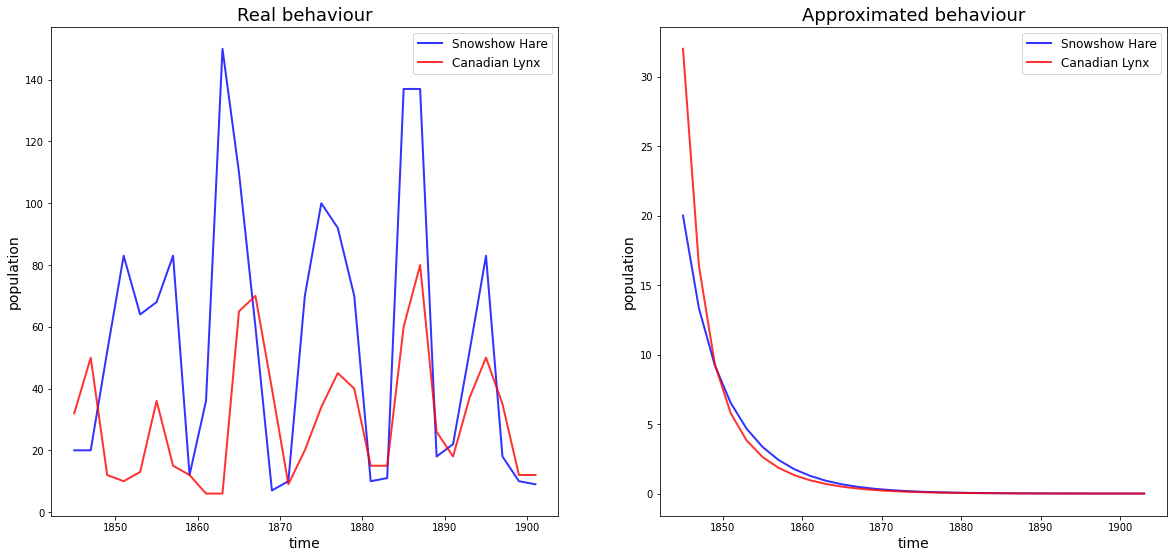

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
plt.show()

## BOP-DMD on the real data-set

In [ ]:
r = 2
imode = 2

X = tmp_data[:,:]

years = np.array(yr)
years = np.reshape(years, (1,len(years)))

w, e, b = optdmd(X,years,r,imode)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


stall detected: residual reduced by less than 1e-12 
times residual at previous step. 
 teration 1 
current residual 0.9678015122048012


/content/drive/MyDrive/PhD/MODELLING FROM MEASUREMENT/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  djacout,jpvt,tau,_,_ = sla.lapack.zgeqp3(djacmat,work)
/content/drive/MyDrive/PhD/MODELLING FROM MEASUREMENT/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  rhstop = sla.lapack.zunmqr('L','C',djacout,tau,res.ravel(order='F')[:,None],lwork)[0]


In [ ]:
# RECONSTRUCTION OF THE PREDICTION

e_reshaped = np.reshape(e, (2,1))
x_dmd = w * np.diag(b) @ np.exp(e_reshaped * years)

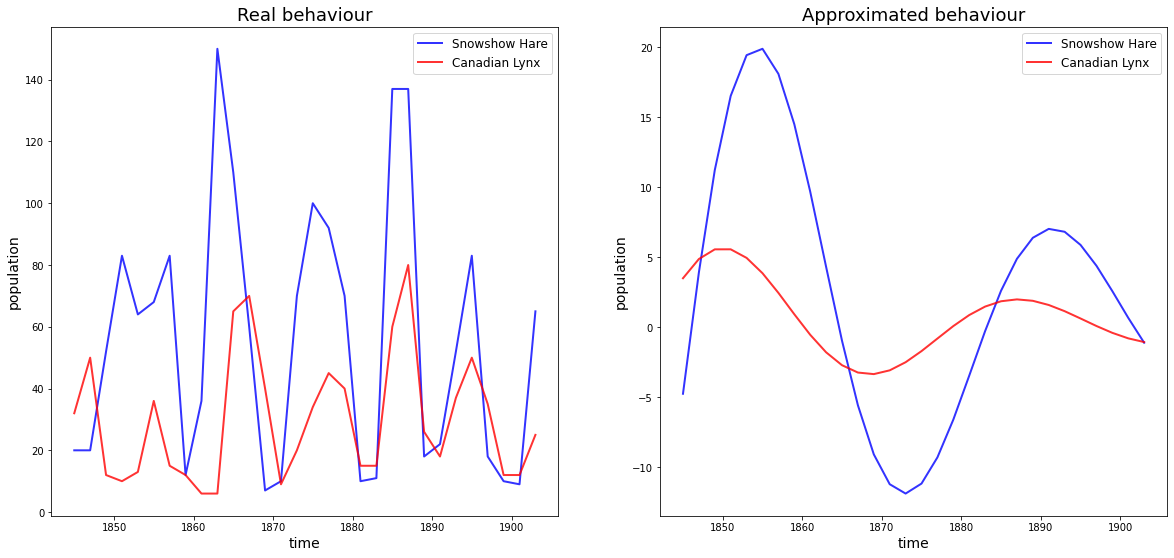

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr[:], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr[:], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
plt.show()

## DMD on the augmented data-set

In [ ]:
# Repeting the same procedure with the interpolated data

tmp_data = np.vstack((sh_new, cl_new))

X = tmp_data[:, :-1]
Xshift = tmp_data[:, 1:]

In [ ]:
r = 2
Phi, Lambda, b = DMD(X, Xshift, r)

x_dmd = DMDprediction(Phi, Lambda, b, yr_new,r)

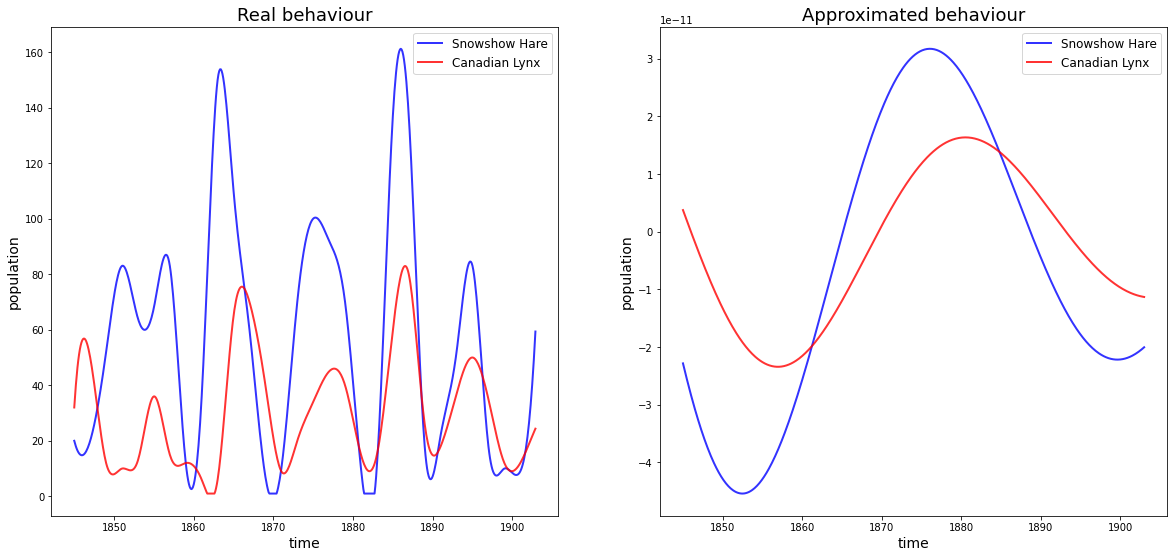

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr_new[:-1], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new[:-1], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr_new, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
plt.show()

## BOP-DMD on the augmented data-set

In [ ]:
r = 2
imode = 2

X = tmp_data[:,:]

years = np.array(yr_new)
years = np.reshape(years, (1,len(years)))

w, e, b = optdmd(X,years,r,imode)

stall detected: residual reduced by less than 1e-12 
times residual at previous step. 
 teration 1 
current residual 0.9766629726988658


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/content/drive/MyDrive/PhD/MODELLING FROM MEASUREMENT/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  djacout,jpvt,tau,_,_ = sla.lapack.zgeqp3(djacmat,work)
/content/drive/MyDrive/PhD/MODELLING FROM MEASUREMENT/Modelling-From-Measurements/Notebooks/Utility/PythonBOPDMD/variableProj.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  rhstop = sla.lapack.zunmqr('L','C',djacout,tau,res.ravel(order='F')[:,None],lwork)[0]


In [ ]:
# RECONSTRUCTION OF THE PREDICTION

e_reshaped = np.reshape(e, (2,1))
x_dmd = w * np.diag(b) @ np.exp(e_reshaped * years)

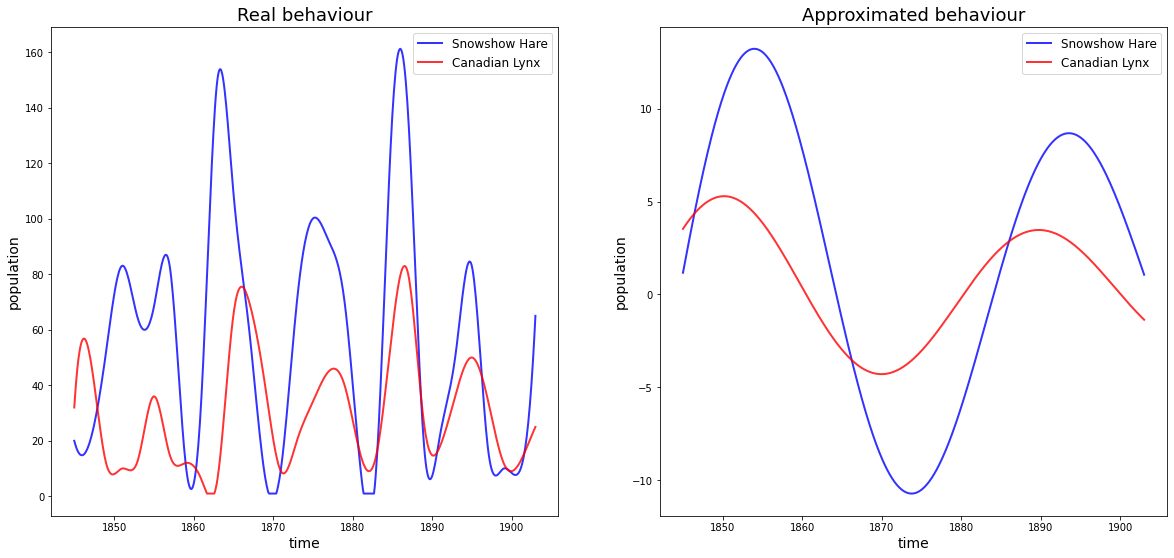

In [ ]:
fig = plt.figure(figsize=(20, 9))

ax = plt.subplot(1,2,1)
h = ax.plot(yr_new[:], X[0, :], linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new[:], X[1, :], linewidth='2', color='red', alpha=0.8)
ax.set_title('Real behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)

ax = plt.subplot(1,2,2)
h = ax.plot(yr_new, np.real(x_dmd[0, :]), linewidth='2', color='blue', alpha=0.8)
h = ax.plot(yr_new, np.real(x_dmd[1, :]), linewidth='2', color='red', alpha=0.8)
ax.set_title('Approximated behaviour', fontsize = 18)
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Snowshow Hare', 'Canadian Lynx'], fontsize = 12)
plt.show()

# Request n° 2
- Do a time-delay DMD model to produce a forecast and compare with regular DMD. Determine if it is likely that there are latent variables. 
    - Try also bagging the DMD to improve the results.

In [ ]:
data = np.vstack((sh_new, cl_new))

t_start = 400
t_window = t_start
x_train = np.ones((100,)) * yr_new[t_start]
y_train = np.arange(0, 150, 150 / 100)

## 10 delay Embeddings

In [ ]:
n_emb = 10

X1 = data[:, :t_start]
X1_shift = data[:, 1:t_start+1]
for i in range(1, n_emb):
    X1 = np.vstack((X1, data[:,i:t_start+i]))
    X1_shift = np.vstack((X1_shift, data[:,i+1:t_start+i+1]))

## 100 delay Embeddings

In [ ]:
n_emb = 100

X2 = data[:, :t_start]
X2_shift = data[:, 1:t_start+1]
for i in range(1, n_emb):
    X2 = np.vstack((X2, data[:,i:t_start+i]))
    X2_shift = np.vstack((X2_shift, data[:,i+1:t_start+i+1]))

## Full Embeddings

In [ ]:
XX = hankel(data[:, :t_start])
X3_tmp = np.zeros_like(XX)
X3_tmp[0::2, :] = XX[:int(XX.shape[0]/2),:]
X3_tmp[1::2, :] = XX[int(XX.shape[0]/2):,:]
X3 = X3_tmp[:, :-1]
X3_shift = X3_tmp[:, 1:]

## SVD on the embeddings

In [ ]:
u1, s1, v1 = np.linalg.svd(X1, full_matrices=False)
u2, s2, v2 = np.linalg.svd(X2, full_matrices=False)
u3, s3, v3 = np.linalg.svd(X3, full_matrices=False)

v1 = v1.conj().T
v2 = v2.conj().T
v3 = v3.conj().T

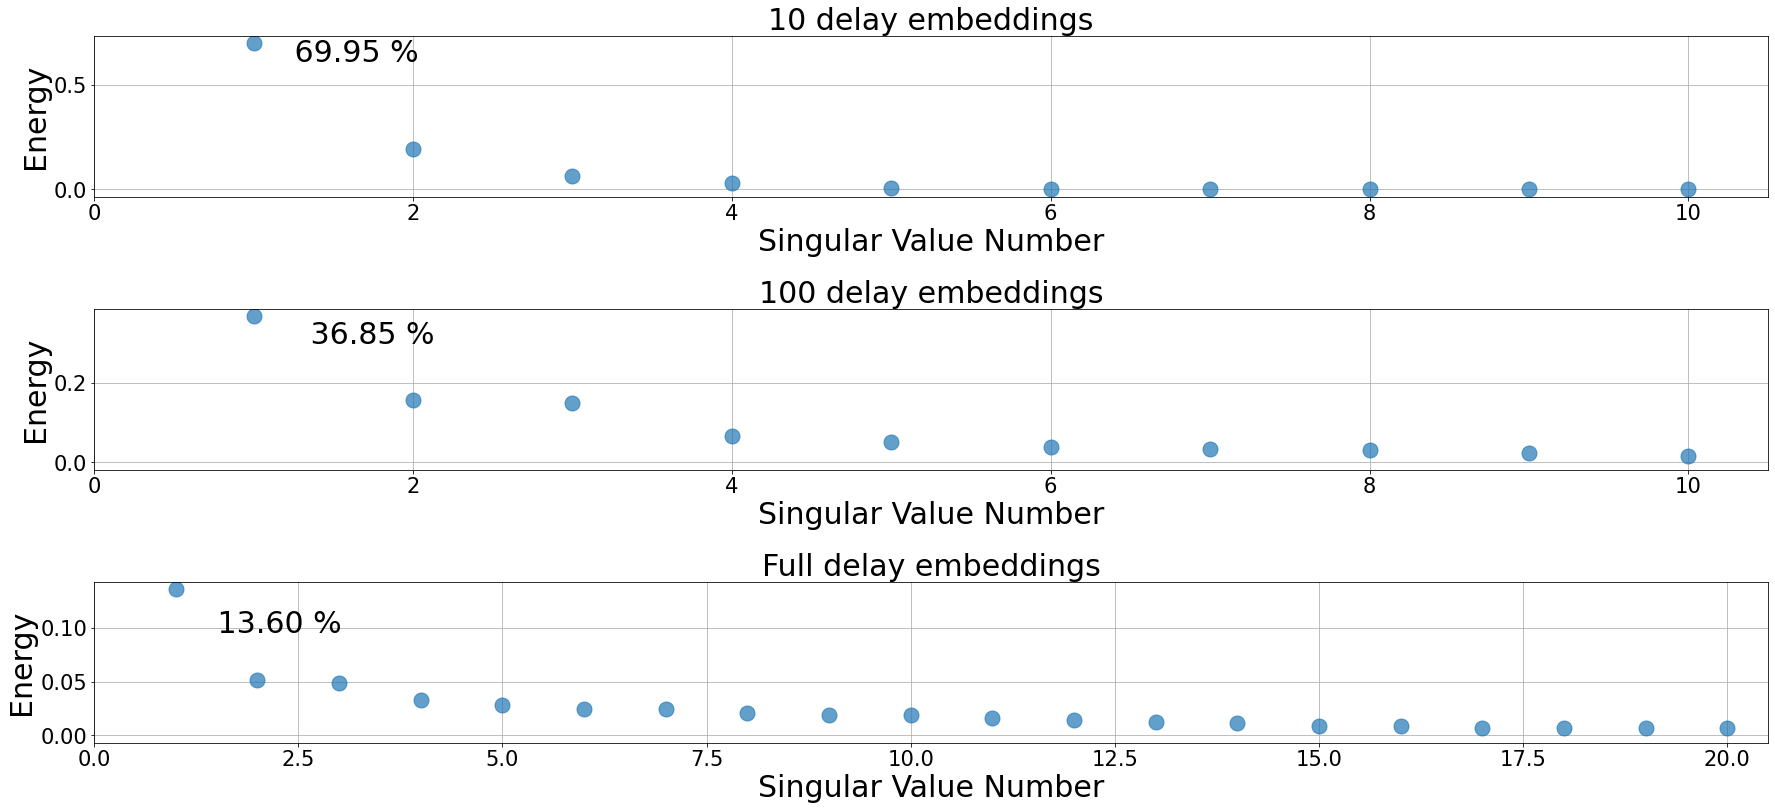

In [ ]:
fig = plt.figure(figsize=(30, 13))

ax = plt.subplot(3, 1, 1)
ax.plot(range(1, len(s1)+1), s1 / np.sum(s1), 'o', markersize = 15, alpha = 0.7)
ax.set_title('10 delay embeddings', fontsize = 30)
ax.text(1.2, (s1[0] / np.sum(s1)) - 0.09, '{:6.2f} %'.format(s1[0] / np.sum(s1) * 100), fontsize=30)
ax.set_xlim([0, 10.5])
ax.set_xlabel('Singular Value Number', fontsize = 30)
ax.set_ylabel('Energy', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=21)
plt.grid()

ax = plt.subplot(3, 1, 2)
ax.plot(range(1, len(s2)+1), s2 / np.sum(s2), 'o', markersize = 15, alpha = 0.7)
ax.set_title('100 delay embeddings', fontsize = 30)
ax.text(1.3, (s2[0] / np.sum(s2)) - 0.07, '{:6.2f} %'.format(s2[0] / np.sum(s2) * 100), fontsize=30)
ax.set_xlim([0, 10.5])
ax.set_xlabel('Singular Value Number', fontsize = 30)
ax.set_ylabel('Energy', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=21)
plt.grid()

ax = plt.subplot(3, 1, 3)
ax.plot(range(1, len(s3)+1), s3 / np.sum(s3), 'o', markersize = 15, alpha = 0.7)
ax.set_title('Full delay embeddings', fontsize = 30)
ax.text(1.4, (s3[0] / np.sum(s3)) - 0.04, '{:6.2f} %'.format(s3[0] / np.sum(s3) * 100), fontsize=30)
ax.set_xlim([0, 20.5])
ax.set_xlabel('Singular Value Number', fontsize = 30)
ax.set_ylabel('Energy', fontsize = 30)
ax.tick_params(axis='both', which='major', labelsize=21)
plt.subplots_adjust(hspace=0.7)
plt.grid()
plt.show()

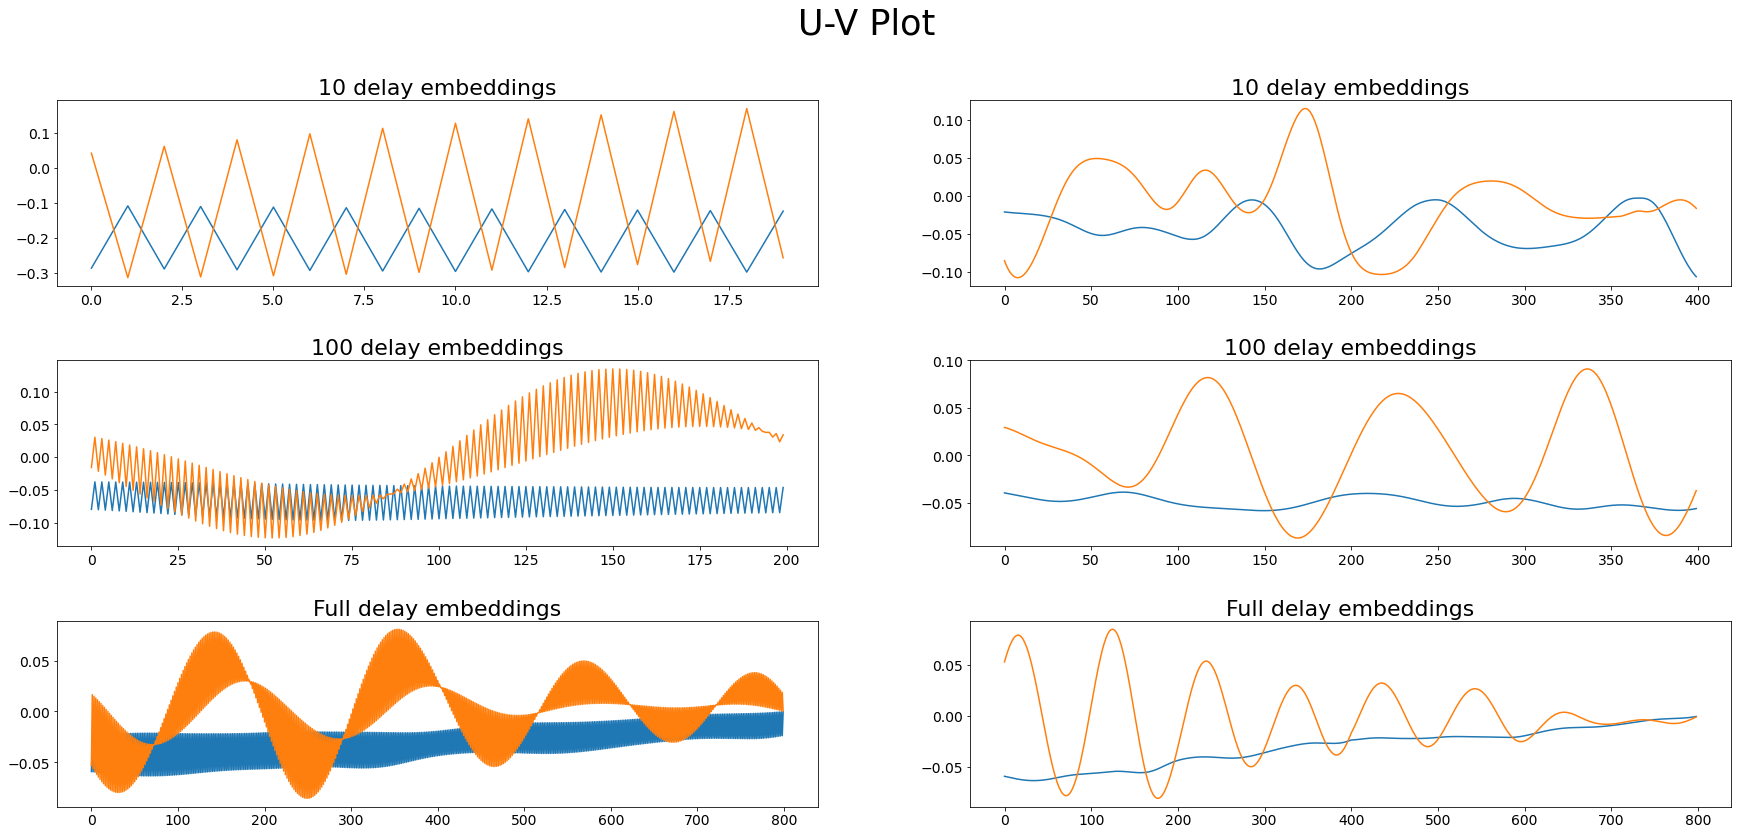

In [ ]:
fig = plt.figure(figsize=(30, 13))
fig.suptitle("U-V Plot", fontsize = 35)

ax = plt.subplot(3, 2, 1)
ax.plot(u1[:, 0])
ax.plot(u1[:, 1])
ax.set_title('10 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 3)
ax.plot(u2[:, 0])
ax.plot(u2[:, 1])
ax.set_title('100 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 5)
ax.plot(u3[:, 0])
ax.plot(u3[:, 1])
ax.set_title('Full delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 2)
ax.plot(v1[:, 0])
ax.plot(v1[:, 1])
ax.set_title('10 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 4)
ax.plot(v2[:, 0])
ax.plot(v2[:, 1])
ax.set_title('100 delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(3, 2, 6)
ax.plot(v3[:, 0])
ax.plot(v3[:, 1])
ax.set_title('Full delay embeddings', fontsize = 22)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
#fig.savefig('Figures/U-V_plot.pdf', format='pdf', dpi=1200)
plt.show()

## DMD to forecast the dynamics of the system

In [59]:
r = 4
U1, S1, V1, X1pred = recondmd(X1,X1_shift,r,t_new)

r = 10
U2, S2, V2, X2pred = recondmd(X2,X2_shift,r,t_new)

r = 40
U3, S3, V3, X3pred = recondmd(X3,X3_shift,r,t_new)

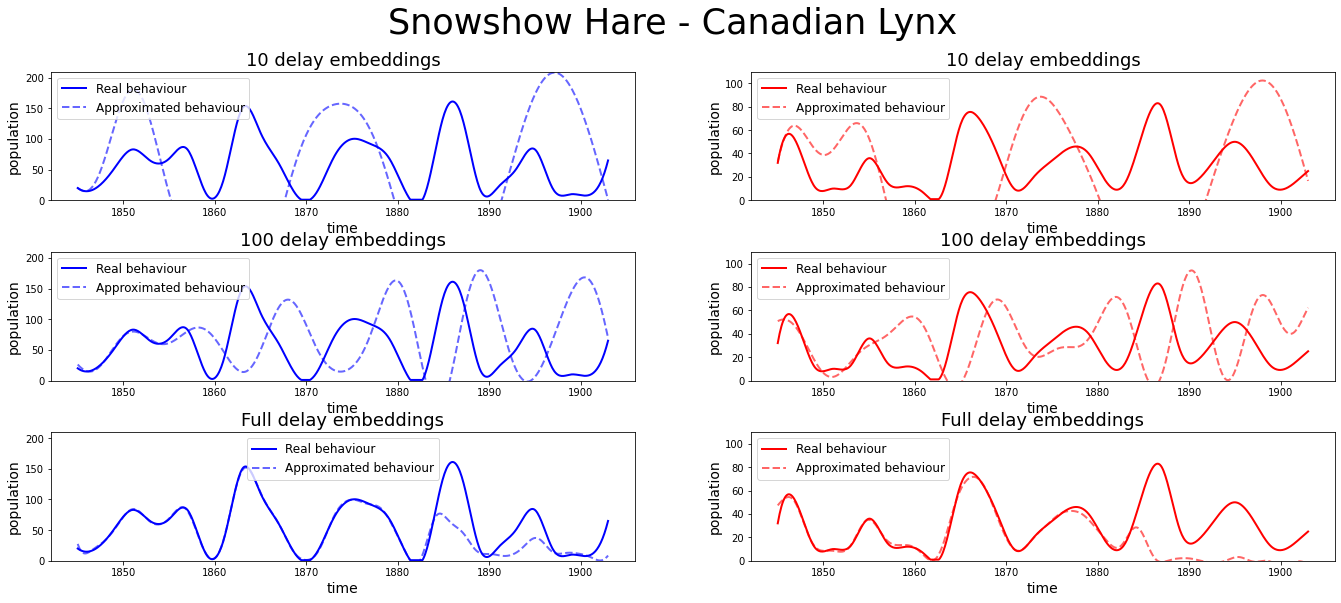

In [60]:
fig = plt.figure(figsize=(23, 9))

plt.suptitle('Snowshow Hare - Canadian Lynx', fontsize = 35)
ax = plt.subplot(3,2,1)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X1pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('10 delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,2)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X1pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('10 delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,3)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X2pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('100 delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,4)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X2pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('100 delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,5)
ax.plot(yr_new[:], X[0, :], linewidth='2', color = 'blue')
ax.plot(yr_new, np.real(X3pred[0, :]), linewidth='2', alpha=0.6, color = 'blue',linestyle='dashed')
ax.set_title('Full delay embeddings', fontsize = 18)
ax.set_ylim([0,210])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

ax = plt.subplot(3,2,6)
ax.plot(yr_new[:], X[1, :], linewidth='2', color = 'red')
ax.plot(yr_new, np.real(X3pred[1, :]), linewidth='2', color = 'red',  linestyle='dashed', alpha=0.6)
ax.set_title('Full delay embeddings', fontsize = 18)
ax.set_ylim([0,110])
plt.xlabel('time', fontsize = 14)
plt.ylabel('population', fontsize = 14)
plt.legend(['Real behaviour', 'Approximated behaviour'], fontsize = 12)

plt.subplots_adjust(hspace=0.4)
plt.show()

# Request n° 3

Empirical Predator-Prey models such as Lotka-Volterra are commonly used to models such phenomenon.
Consider the model:
\begin{gather*}
\dot{x} = (b-py)x \\
\dot{y} = (rx-d)y
\end{gather*}
Use the data to approximately fit values of b, p, r and d. \
In general we would like to solve such system of equation:
\begin{gather*}
bx - pxy = \dot{x} \\
rxy - dy = \dot{y}
\end{gather*}
Which can be seen as: 
$$\underline{\underline{A}} * \underline{x} = \underline{\dot{x}}$$
$$\begin{bmatrix} b & -p & 0 \\ 0 & r & -d\end{bmatrix} \begin{bmatrix} x \\ xy \\ y \end{bmatrix} = \begin{bmatrix} \dot{x} \\ \dot{y}\end{bmatrix}$$

In [ ]:
dt = 0.1
years = yr_new
t = t_new

X1 = sh_new # Snowshoe
X2 = cl_new # Canadian Lynx

In [ ]:
X1dot = np.zeros(X1.shape)
X2dot = np.zeros(X2.shape)

for i in range(1, len(t) - 1):

    X1dot[i] = (X1[i+1] - X1[i-1]) / (2 * dt)
    X2dot[i] = (X2[i+1] - X2[i-1]) / (2 * dt)

X1_train = np.vstack((X1, -X1*X2))
X2_train = np.vstack((X1*X2, -X2)) 

In [ ]:
ridge_sh = Ridge(alpha = 0.1)
ridge_cl = Ridge(alpha = 0.1)
lasso_sh = Lasso(alpha = 0.1)
lasso_cl = Lasso(alpha = 0.1)
linear_sh = LinearRegression()
linear_cl = LinearRegression()

sh_fit_ridge = ridge_sh.fit(X1_train.T, X1dot)
cl_fit_ridge = ridge_cl.fit(X2_train.T, X2dot)

sh_fit_lasso = lasso_sh.fit(X1_train.T, X1dot)
cl_fit_lasso = lasso_cl.fit(X2_train.T, X2dot)

sh_fit_linear = linear_sh.fit(X1_train.T, X1dot)
cl_fit_linear = linear_cl.fit(X2_train.T, X2dot)

In [ ]:
b_ridge = sh_fit_ridge.coef_[0]
p_ridge = sh_fit_ridge.coef_[1]
r_ridge = cl_fit_ridge.coef_[0]
d_ridge = cl_fit_ridge.coef_[1]

b_lasso = sh_fit_lasso.coef_[0]
p_lasso = sh_fit_lasso.coef_[1]
r_lasso = cl_fit_lasso.coef_[0]
d_lasso = cl_fit_lasso.coef_[1]

b_linear = sh_fit_linear.coef_[0]
p_linear = sh_fit_linear.coef_[1]
r_linear = cl_fit_linear.coef_[0]
d_linear = cl_fit_linear.coef_[1]

table = [["b", b_linear, b_lasso, b_ridge],
        ["p", p_linear, p_lasso, p_ridge],
        ["r", r_linear, r_lasso, r_ridge],
        ["d", d_linear, d_lasso, d_ridge]]

print(tabulate(table, headers=["Parameter","LinearRegression", "Lasso", "Ridge"], tablefmt="github"))

| Parameter   |   LinearRegression |      Lasso |      Ridge |
|-------------|--------------------|------------|------------|
| b           |         0.2601     | 0.259962   | 0.2601     |
| p           |         0.00556152 | 0.00555986 | 0.00556152 |
| r           |         0.00340555 | 0.00340093 | 0.00340555 |
| d           |         0.361533   | 0.360798   | 0.361532   |


In [ ]:
x0 = [X1[0], X2[0]]
t_test = np.arange(t[0], t[-1]+0.1, 0.1)

sol_linear = solve_ivp(LotkaVolterra, 
                [t[0], t[-1]], 
                x0, 
                args=(b_linear, p_linear, d_linear, r_linear),
                t_eval = t_test, 
                method = 'RK45')
                
t_linear = sol_linear['t']
sol_linear = np.vstack((sol_linear['y'][0], sol_linear['y'][1]))

In [ ]:
x0 = [X1[0], X2[0]]
t_test = np.arange(t[0], t[-1]+0.1, 0.1)

sol_lasso = solve_ivp(LotkaVolterra, 
                [t[0], t[-1]], 
                x0, 
                args=(b_lasso, p_lasso, d_lasso, r_lasso),
                t_eval = t_test, 
                method = 'RK45')
                
t_lasso = sol_lasso['t']
sol_lasso = np.vstack((sol_lasso['y'][0], sol_lasso['y'][1]))

In [ ]:
x0 = [X1[0], X2[0]]
t_test = np.arange(t[0], t[-1]+0.1, 0.1)

sol_ridge = solve_ivp(LotkaVolterra, 
                [t[0], t[-1]], 
                x0, 
                args=(b_ridge, p_ridge, d_ridge, r_ridge),
                t_eval = t_test, 
                method = 'RK45')
                
t_ridge = sol_ridge['t']
sol_ridge = np.vstack((sol_ridge['y'][0], sol_ridge['y'][1]))

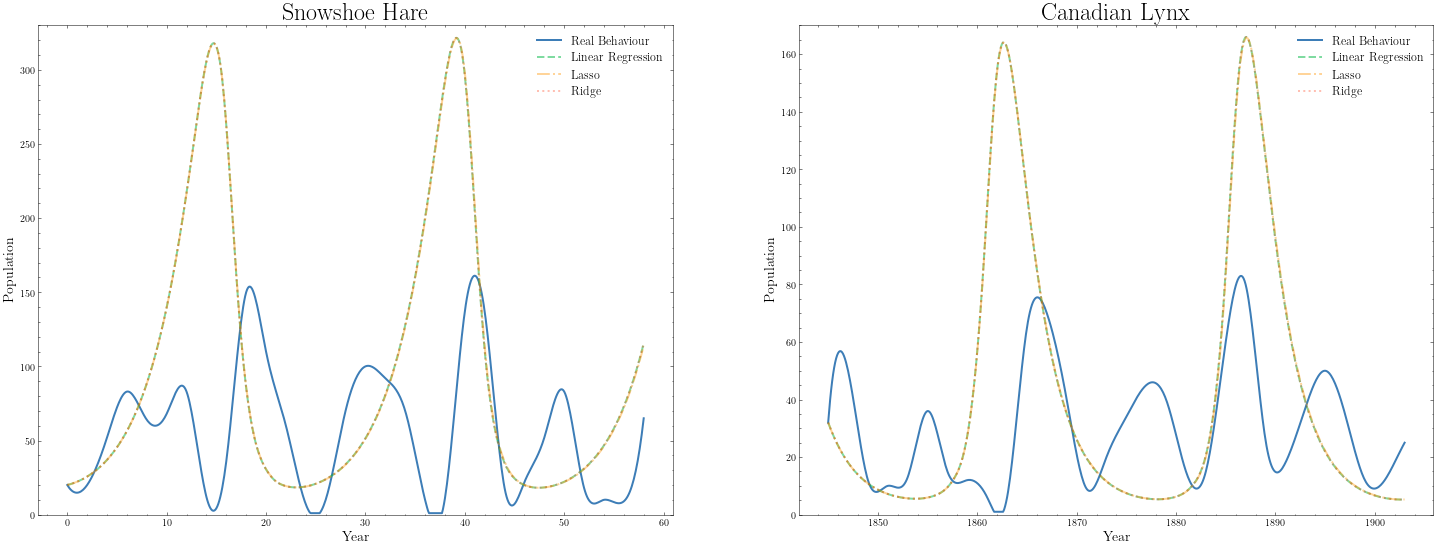

In [ ]:
fig = plt.figure(figsize=(25, 9))

ax = plt.subplot(1,2,1)
ax.set_title('Snowshoe Hare', fontsize = 24)
ax.plot(yr_new[:], X[0, :], linewidth='2', alpha=0.8)
ax.plot(yr_new, sol_linear[0,:], linewidth='2', alpha=0.5, linestyle='dashed')
ax.plot(yr_new, sol_lasso[0,:], linewidth='2', alpha=0.4, linestyle='dashdot')
ax.plot(yr_new, sol_ridge[0,:], linewidth='2', alpha=0.3, linestyle=':')
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Population', fontsize = 14)
ax.set_ylim([0,330])
plt.legend(['Real Behaviour', 'Linear Regression', 'Lasso', 'Ridge'], fontsize = 12)

ax = plt.subplot(1,2,2)
ax.set_title('Canadian Lynx', fontsize = 24)
ax.plot(yr_new[:], X[1, :], linewidth='2', alpha=0.8)
ax.plot(yr_new, sol_linear[1,:], linewidth='2', alpha=0.5, linestyle='dashed')
ax.plot(yr_new, sol_lasso[1,:], linewidth='2', alpha=0.4, linestyle='dashdot')
ax.plot(yr_new, sol_ridge[1,:], linewidth='2', alpha=0.3, linestyle=':')
ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Population', fontsize = 14)
ax.set_ylim([0,170])
plt.legend(['Real Behaviour', 'Linear Regression', 'Lasso', 'Ridge'], fontsize = 12)

fig.savefig('Figures/L-V-parameters-estimation.pdf', format='pdf', dpi=1200)
plt.show()

# Request n° 4

- Find the best fit nonlinear, dynamical systems model to the data using bagging sparse regression SINDy (See: https://github.com/dynamicslab/pysindy/blob/master/examples/13_ensembling.ipynb)

Check the following paper: Fasel, Urban, et al. "Ensemble-SINDy: Robust sparse model discovery in the low-data, high-noise limit, with active learning and control." arXiv preprint arXiv:2111.10992 (2021). https://arxiv.org/abs/2111.10992

In [ ]:
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-20
integrator_keywords['method'] = 'RK45' # Probably works also with 'RK45'
integrator_keywords['atol'] = 1e-18

np.random.seed(100)

In [ ]:
dt = 0.001
years = yr_new
t = t_new

X1 = sh_new # Snowshoe
X2 = cl_new # Canadian Lynx

t_train = np.arange(min(years), max(years), dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [0.1, 0.001]

x_train = solve_ivp(lotka,
                [t_train[0], t_train[-1]],
                x0_train,
                t_eval = t_train, 
                **integrator_keywords).y.T

rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train = x_train + np.random.normal(0, rmse / 100.0, x_train.shape)

# Evolve the Lotka-Volterra equations in time using a different initial condition
t_test = np.arange(min(years), max(years) + 10, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = [0.01 + 0.5,  0.63]

x_test = solve_ivp(lotka,
                [t_test[0], t_test[-1]],
                x0_test,
                t_eval = t_test, 
                **integrator_keywords).y.T

feature_names = ['x', 'y']


In [ ]:
ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=ensemble_optimizer)
model.fit(x_train, t=dt, ensemble=True, n_models=1000, quiet=True)
model.print()
ensemble_coefs = np.asarray(model.coef_list)

(x)' = 1.020 x + 0.134 y + -10.234 x y + -0.170 y^2
(y)' = -1.945 y + 10.061 x y


In [ ]:
library_ensemble_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=library_ensemble_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, n_models=1000, quiet=True)
model.print()
library_ensemble_coefs = np.asarray(model.coef_list)

(x)' = 1.001 x + -10.004 x y
(y)' = -1.998 y + 9.995 x y


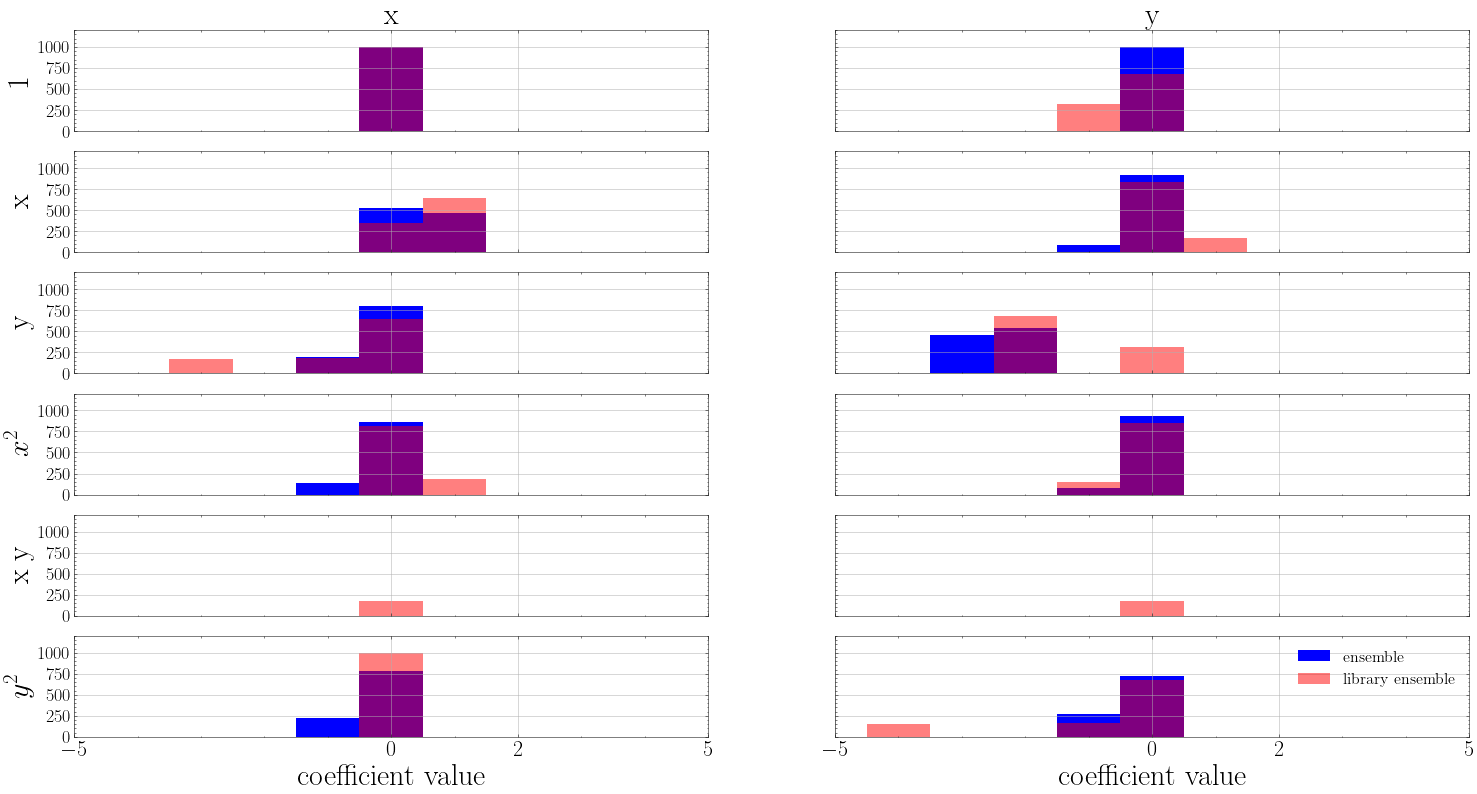

In [ ]:
fig = plt.figure(figsize=(25, 13))
xticknames = model.get_feature_names()
xticknames = ['1', 'x', 'y', '$x^{2}$', 'x y', '$y^{2}$']
min_overall = -5
max_overall = 5

for i in range(6):
    for j in range(2):
        ax = plt.subplot(6, 2, j + 1 + i * 2)
        if(i == 0):
            ax.set_title(feature_names[j], fontsize=30)

        bins = np.linspace(min_overall, max_overall, max_overall - min_overall + 1)
        ax.hist(ensemble_coefs[:, j, i], color='b',bins = bins, label='ensemble', align='left')
        ax.hist(library_ensemble_coefs[:, j, i], color='r', bins = bins, alpha=0.5, label='library ensemble', align='left')

        ax.grid(True)
        
        if(j == 0):
            ax.set_ylabel(xticknames[i], fontsize=30)
        else:
            ax.set_yticklabels([])
        if(i != 5):
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('coefficient value', fontsize=30)
        
        ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        ax.set_ylim(0, 1200)
        ax.set_xlim(min_overall, max_overall)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=18)
        if (j == 1 and i == 5):
            plt.legend(fontsize=16)

fig.savefig('Figures/CoefficientValues_distribution.pdf', format='pdf', dpi=1200)
plt.show()

In [ ]:
prediction = model.simulate(x0_test, t_test, integrator_kws=integrator_keywords)

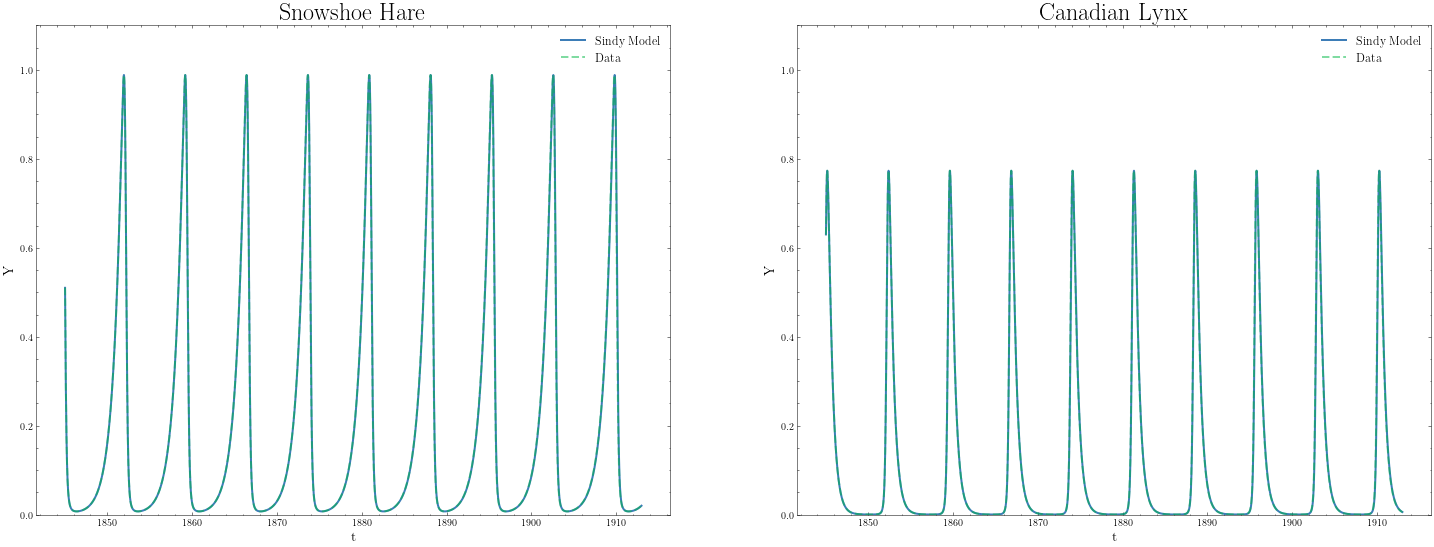

In [ ]:
fig = plt.figure(figsize=(25, 9))

ax = plt.subplot(1,2,1)
ax.set_title('Snowshoe Hare', fontsize = 24)
ax.plot(t_test, prediction[:,0], linewidth='2', alpha=0.8)
ax.plot(t_test, x_test[:, 0], linewidth='2', alpha=0.5, linestyle='dashed')
ax.set_xlabel('t', fontsize = 14)
ax.set_ylabel('Y', fontsize = 14)
plt.ylim([0,1.1])
plt.legend(['Sindy Model', 'Data'], fontsize = 12)

ax = plt.subplot(1,2,2)
ax.set_title('Canadian Lynx', fontsize = 24)
ax.plot(t_test, prediction[:,1], linewidth='2', alpha=0.8)
ax.plot(t_test, x_test[:, 1], linewidth='2', alpha=0.5, linestyle='dashed')
ax.set_xlabel('t', fontsize = 14)
ax.set_ylabel('Y', fontsize = 14)
plt.ylim([0,1.1])
plt.legend(['Sindy Model', 'Data'], fontsize = 12)

fig.savefig('Figures/SindyEstimation.pdf', format='pdf', dpi=1200)
plt.show()